In [2]:
%reload_ext autoreload
%autoreload 2
%cd llama3/llama

/home/tbai4/llama3/llama


/home/tbai4/llama3/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
from llama import Workflow, Llama

os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29500"

workflow = Workflow.build(
    ckpt_dir='/scratch4/jeisner1/tjbai/llama_8b',
    tokenizer_path='/scratch4/jeisner1/tjbai/llama_8b/tokenizer.model',
    max_seq_len=8192,
    max_batch_size=8,
    model_parallel_size=1,
    max_nodes=100,
)

llama = Llama(workflow.model, workflow.tokenizer)

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1
Loaded in 11.76 seconds


## distinguishing trick prompts

In [ ]:
from tqdm import tqdm
from llama.benchmark.tot import tricky_tot_cached, tricky_tot_baseline, load_math_problems

problems = load_math_problems('../data/MATH', split='train', problem_types=['counting_and_probability'])[:100]

votes_baseline = []
trick_indices_baseline = []
workflow.model.reshape_cache(8)

for problem in tqdm(problems):
    outputs = tricky_tot_baseline(
        llama=llama,
        problem=problem['problem'],
        branching_factor=8,
        voters=4
    )
    votes_baseline.append(outputs['votes'])
    trick_indices_baseline.append(outputs['trick_indices'])

votes_cached = []
trick_indices_cached = []
workflow.model.reshape_cache(1)

for problem in tqdm(problems):
    workflow.reset()
    outputs = tricky_tot_cached(
        workflow=workflow,
        problem=problem['problem'],
        branching_factor=8,
        voters=4,
    )
    votes_cached.append(outputs['votes'])
    trick_indices_cached.append(outputs['trick_indices'])
    
import json
with open('trick_results.json', 'w') as f:
    json.dump({
        'votes_baseline': votes_baseline,
        'trick_indices_baseline': trick_indices_baseline,
        'votes_cached': votes_cached,
        'trick_indices_cached': trick_indices_cached
    }, f)

  5%|▌         | 5/100 [01:58<37:46, 23.86s/it]

## check fa2

In [20]:
import os
import torch
import torch.nn.functional as F

os.environ['TORCH_SHOW_CPP_STACKTRACES'] = '1'

def check_flash_attention(q, k, v):
    try:
        with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=False):
            out = F.scaled_dot_product_attention(q, k, v)    
        print("Backend selection succeeded")
        return True
    except RuntimeError as e:
        print(f"Error: {str(e)}")
        if "Flash attention" in str(e):
            print("Flash Attention attempted but failed - likely not supported for this input")
        return False

B, H, L, D = 1, 8, 1024, 64
q = torch.randn(B, H, L, D, device='cuda', dtype=torch.bfloat16)
k = torch.randn(B, H, L, D, device='cuda', dtype=torch.bfloat16)
v = torch.randn(B, H, L, D, device='cuda', dtype=torch.bfloat16)

check_flash_attention(q, k, v)

Backend selection succeeded


True

## benchmark sequence encoding time

Benchmarking on cuda

Batch Size | Seq Length | Time (ms) 
4          | 128        | 49.45
4          | 256        | 90.05
4          | 512        | 169.24
4          | 1024       | 336.14
8          | 128        | 89.28
8          | 256        | 166.18
8          | 512        | 323.27
8          | 1024       | 665.83
16         | 128        | 165.12
16         | 256        | 318.23
16         | 512        | 640.45
16         | 1024       | 1308.69
32         | 128        | 316.21
32         | 256        | 628.86
32         | 512        | 1259.31
32         | 1024       | 2623.93


,Batch Size,Seq Length,Time (ms)
0,4,128,49.450207
1,4,256,90.050149
2,4,512,169.244862
3,4,1024,336.142778
4,8,128,89.275503
5,8,256,166.176224
6,8,512,323.270226
7,8,1024,665.825009
8,16,128,165.116787
9,16,256,318.226790


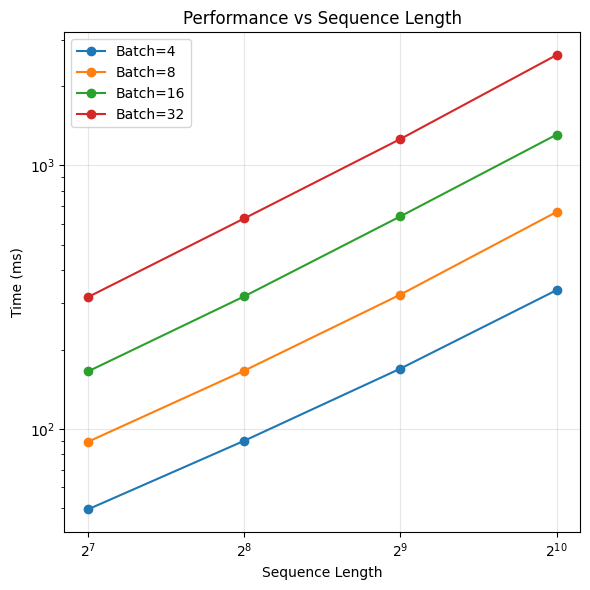

In [11]:
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt

def benchmark_and_plot(workflow, cache_size=32):
    workflow.model.reshape_cache(cache_size)
    workflow.reset()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = workflow.model
    tokenizer = workflow.tokenizer

    batch_sizes = [4, 8, 16, 32]
    seq_lengths = [128, 256, 512, 1024]
    num_repeats = 10
    warmup_steps = 3

    print(f"Benchmarking on {device}\n")
    print(f"{'Batch Size':<10} | {'Seq Length':<10} | {'Time (ms)':<10}")

    results = {
        'Batch Size': [],
        'Seq Length': [],
        'Time (ms)': []
    }

    for batch_size in batch_sizes:
        for seq_len in seq_lengths:
            input_ids = torch.full((batch_size, seq_len), tokenizer.eot_id, device=device)
            
            with torch.no_grad():
                for _ in range(warmup_steps):
                    _ = model.forward(input_ids, start_pos=0)

            total_time = 0.0
            with torch.no_grad():
                for _ in range(num_repeats):
                    torch.cuda.synchronize()
                    start_time = time.time()
                    _ = model(input_ids, start_pos=0)
                    torch.cuda.synchronize()
                    total_time += (time.time() - start_time) * 1000

            avg_time = total_time / num_repeats
            print(f"{batch_size:<10} | {seq_len:<10} | {avg_time:.2f}")
            
            results['Batch Size'].append(batch_size)
            results['Seq Length'].append(seq_len)
            results['Time (ms)'].append(avg_time)

    df = pd.DataFrame(results)
    
    plt.figure(figsize=(6, 6))
    for batch in df['Batch Size'].unique():
        batch_data = df[df['Batch Size'] == batch]
        plt.plot(batch_data['Seq Length'], batch_data['Time (ms)'], 
                marker='o', label=f'Batch={batch}')

    plt.xlabel('Sequence Length')
    plt.ylabel('Time (ms)')
    plt.title('Performance vs Sequence Length')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.yscale('log')
    plt.xscale('log', base=2)
    plt.tight_layout()
    
    return df

benchmark_and_plot(workflow, cache_size=32)

In [3]:
import json
from pathlib import Path
from llama.benchmark.tot import benchmark_tot

def load_math_problems(root_dir, split, problem_types):
    problems = []
    root = Path(root_dir) / split
    
    for problem_type in problem_types:
        type_dir = root / problem_type
        if not type_dir.exists():
            continue
            
        for prob_file in type_dir.glob("*.json"):
            with open(prob_file) as f:
                problem = json.load(f)
                problems.append(problem)
    
    return problems

problems = load_math_problems('../data/MATH', 'train', ['counting_and_probability'])

baseline_result, cached_result = benchmark_tot(
    llama=llama,
    workflow=workflow,
    problem=problems[0]['problem'],
    branching_factor=4,
    voters=4,
)

print(baseline_result['mean'])
print(cached_result['mean'])

Reshaped cache to 4 X 16384
Reshaped cache to 1 X 65536
18.05689761217218
17.885423328261822


In [ ]:
from llama.benchmark.tot import sweep_tot

sweep_tot(
    llama=llama,
    workflow=workflow,
    math_path='../data/MATH',
    branch_sizes=[2, 4, 8],
    voter_sizes=[2, 4],
    n_problems=5,
    split='train',
    problem_types=['counting_and_probability'],
    save_path='benchmark_tot.json'
)

In [ ]:
workflow.reset()

[generate_prompt, evaluate_prompt] = workflow.insert([
    {
        'messages': [
            {'role': 'system', 'content': 'You will be shown a math problem. Provide a high-level summary of how to solve the problem.'},
            {'role': 'user', 'content': 'Here is the problem: How many ways can you sit 10 different people around a round table?'}
        ],
        'parent_ids': [],
    },
    {
        'messages': [
            {'role': 'system', 'content': 'Given a math problem and numerous proposed solutions, echo back to the user all of the solutions.'},
        ],
        'parent_ids': []
    }
])

resp1, resp2 = workflow.insert([
    {
        'messages': [{'role': 'assistant', 'content': 'We can possibly use binomial coefficients to solve this problem via combinations.'}],
        'parent_ids': [generate_prompt['id']],
    },
    {
        'messages': [{'role': 'assistant', 'content': 'We can consider all 10 permutations and cancel out the rotational symmetry.'}],
        'parent_ids': [evaluate_prompt['id']],
    },
])

tokens, cached = workflow.step(
    tasks=[
        {
            'header': ('assistant', None),
            'prefill': 'The user proposed doing',
            'parent_ids': [evaluate_prompt['id'], resp2['id'], resp1['id']],

        }
        for _ in range(4)
    ],
    compact=True,
    max_gen_len=128,
    temperature=1.0,
    top_p=1.0,
    seed=1,
)

for i, output in enumerate(tokens):
    print(f'example #{i+1}')
    print(workflow.tokenizer.decode(output))
    print()

In [ ]:
import torch

workflow.model = workflow.model.to(torch.bfloat16)
llama.model = llama.model.to(torch.bfloat16)

completion = llama.chat_completion([[
    {'role': 'system', 'content': 'Answer the user\'s question please.'},
    {'role': 'user', 'content': 'What is the capital of France?'},
    {'role': 'user', 'content': 'What is the capital of Germany?'},
]], max_gen_len=32)

print(completion)

regular_cache_v = llama.model.layers[0].attention.cache_v[0].clone()
regular_cache_k = llama.model.layers[0].attention.cache_k[0].clone()

workflow.reset()

[system] = workflow.insert([
    {
        'messages': [{'role': 'system', 'content': 'Answer the user\'s question please.'}],
        'parent_ids': [],
    },
])

[user_1] = workflow.insert([
    {
        'messages': [{'role': 'user', 'content': 'What is the capital of France?'}],
        'parent_ids': [system['id']],
    },
])

[user_2] = workflow.insert([
   {
        'messages': [{'role': 'user', 'content': 'What is the capital of Germany?'}],
        'parent_ids': [system['id'], user_1['id']],
    }
])

workflow_cache_v = workflow.model.layers[0].attention.cache_v[0].clone()
workflow_cache_k = workflow.model.layers[0].attention.cache_k[0].clone()

for n in range(workflow.cache_len):
    print(n, (workflow_cache_v[n] - regular_cache_v[n]).max())
    print(n, (workflow_cache_k[n] - regular_cache_k[n]).max())
    
workflow.model = workflow.model.bfloat16()
llama.model = llama.model.bfloat16()

In [5]:
import re
from collections import Counter

cot_prompt = '''
You are a creative problem solver with deep expertise in competition mathematics.
Your goal is to propose a clean and insightful approach to solving the provided problem.
Keep your proposal high-level and CONCISE. Do not attempt to solve the entire problem.

You must format your response as:
APPROACH:
1. (high-level first step)
2. (high-level second step)
'''

finish_prompt = '''
You are a creative problem solver with deep expertise in competition mathematics.
You will be provided a problem and a proposed approach to solving it. Using the steps provided, finish solving the problem.
Keep your solution CONCISE and lean on ideas developed in the proposal.
You MUST provide the final answer to the problem and will be graded on correctness.

You must format your response as:
ANSWER: (2-3 sentence summary of solution and final answer)
'''

def format_vote_prompt(n):
    return f'''
    You are a rigorous mathematical evaluator with deep expertise in competition mathematics.
    You will be shown several different solution strategies for a math problem.
    Vote on the best proposal and give a CONCISE justification of your choice.
    You will see {n} proposals, so respond with the proposal 1 through {n}.
    Do not attempt to solve the problem. You only need to evaluate each proposal and select the best option.

    You must format your response as:
    BEST CHOICE: (index of best solution)
    RATIONALE: (1 sentence justification)
    '''

def format_problem(problem):
    return f'Here is the provided problem:\n{problem}'

def parse_choice(text):
    match = re.search(r'BEST CHOICE:\s*(\d+)', text)
    if match:
        return int(match.group(1))
    return None

def solve(problem, branching_factor, voters):
    workflow.reset()

    cot, vote, finish = workflow.insert([
        {
            'messages': [{'role': 'system', 'content': cot_prompt}, {'role': 'user', 'content': format_problem(problem)}],
            'parent_ids': []
        },
        {
            'messages': [{'role': 'system', 'content': format_vote_prompt(branching_factor)}, {'role': 'user', 'content': format_problem(problem)}],
            'parent_ids': []
        },
        {
            'messages': [{'role': 'system', 'content': finish_prompt}, {'role': 'user', 'content': format_problem(problem)}],
            'parent_ids': []
        },
    ])
    
    proposal_tokens, proposal_nodes = workflow.step(
        [
            {
                'header': ('assistant', None),
                'prefill': f'Solution #{i+1}:\n\n',
                'parent_ids': [cot['id']]
            }
            for i in range(branching_factor)
        ],
        compact=False,
        max_gen_len=512,
        temperature=0.7,
        top_p=0.9,
        seed=42,
        debug=False,
    )
    
    vote_tokens, vote_nodes = workflow.step(
        [
            {
                'header': ('assistant', None),
                'prefill': 'BEST CHOICE: ',
                'parent_ids': [vote['id']] + list([p['id'] for p in proposal_nodes])
            }
            for _ in range(voters)
        ],
        compact=False,
        max_gen_len=256,
        temperature=0.7,
        top_p=0.9,
        seed=42,
        debug=False
    )
    
    res = None
    votes = [
        choice for resp in vote_tokens if 
        (choice := parse_choice(workflow.tokenizer.decode(resp))) is not None
    ]
    
    if len(votes) > 0:
        best = Counter(votes).most_common(1)[0][0]
        [res], _ = workflow.step(
            [
                {
                    'header': ('assistant', None),
                    'parent_ids': [finish['id']] + [proposal_nodes[best-1]['id']]
                }
            ],
            compact=False,
            max_gen_len=256,
            temperature=0.7,
            top_p=0.9,
            seed=42,
            debug=False
        )

    return proposal_tokens, vote_tokens, res, votes

import time
s = time.time()
proposal_tokens, vote_tokens, res, votes = solve(problems[0]['problem'], branching_factor=5, voters=10)
print(time.time() - s)

14.576764345169067


In [14]:
import time

branching_factor = 2
voters = 2

problem = problems[0]['problem']

workflow.reset()

cot, vote, finish = workflow.insert([
    {
        'messages': [{'role': 'system', 'content': cot_prompt}, {'role': 'user', 'content': format_problem(problem)}],
        'parent_ids': []
    },
    {
        'messages': [{'role': 'system', 'content': format_vote_prompt(branching_factor)}, {'role': 'user', 'content': format_problem(problem)}],
        'parent_ids': []
    },
    {
        'messages': [{'role': 'system', 'content': finish_prompt}, {'role': 'user', 'content': format_problem(problem)}],
        'parent_ids': []
    },
])

proposal_tokens, proposal_nodes = workflow.step(
    [
        {
            'header': ('assistant', None),
            'prefill': f'Solution #{i+1}:\n\n',
            'parent_ids': [cot['id']]
        }
        for i in range(branching_factor)
    ],
    compact=False,
    max_gen_len=512,
    temperature=0.7,
    top_p=0.9,
    seed=42,
    debug=False,
)

vote_tokens, vote_nodes = workflow.step(
    [
        {
            'header': ('assistant', None),
            'prefill': 'BEST CHOICE: ',
            'parent_ids': [vote['id']] + list([p['id'] for p in proposal_nodes])
        }
        for _ in range(voters)
    ],
    compact=False,
    max_gen_len=256,
    temperature=0.7,
    top_p=0.9,
    seed=42,
    debug=False
)